# 股票視覺化分析與進出場投資策略設計

### 目的：分析基本面/技術面與進行視覺化圖表分析製作，並依據基本/技術面設計進出場投資策略

In [1]:
# import需要的套件
import ffn
%matplotlib inline
import pandas_datareader.data as web
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import requests
import json

In [19]:
# 從yahoo finance爬取股票資料（使用API並選擇起始與結束日期，開始爬取），整理資料 #以2330為例
url = "https://query1.finance.yahoo.com/v8/finance/chart/2330.TW?period1=1549258857&period2=1588035600&interval=1d&events=history&=hP2rOschxO0"

res = requests.get(url)
data = json.loads(res.text)
df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
df.tail() # 檢查最新資料是否為所選日期（今天4/28 ）

,high,volume,low,close,open
2020-04-22 01:00:00,295.0,42192580,290.5,294.0,294.5
2020-04-23 01:00:00,300.0,39474478,294.0,295.5,300.0
2020-04-24 01:00:00,297.0,26008090,294.0,294.0,295.5
2020-04-27 01:00:00,298.5,38493406,296.0,298.0,298.0
2020-04-28 05:30:02,298.5,37164000,294.5,296.5,298.5


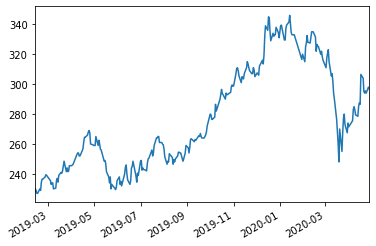

In [20]:
df.close.plot() #製作收盤價趨勢折線圖

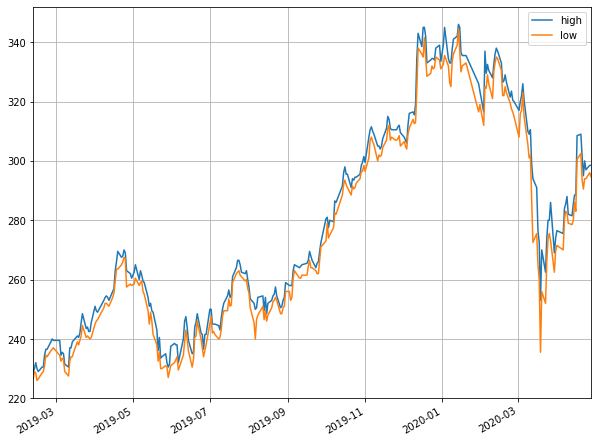

In [51]:
# 比較最高與最低價的每日差異
df[['high','low']].plot(grid=True, figsize=(10,8))

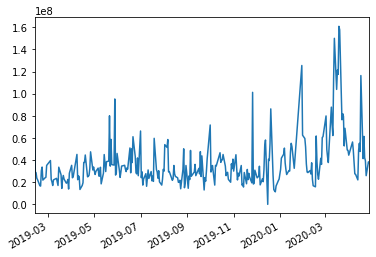

In [55]:
# 成交量折線圖
df.volume.plot()

In [21]:
# 以pandas的套件，用收盤價計算出20日、60日的收盤價均值
df['20d'] = pd.Series.rolling(df['close'], window=20).mean()
df['60d'] = pd.Series.rolling(df['close'], window=60).mean()

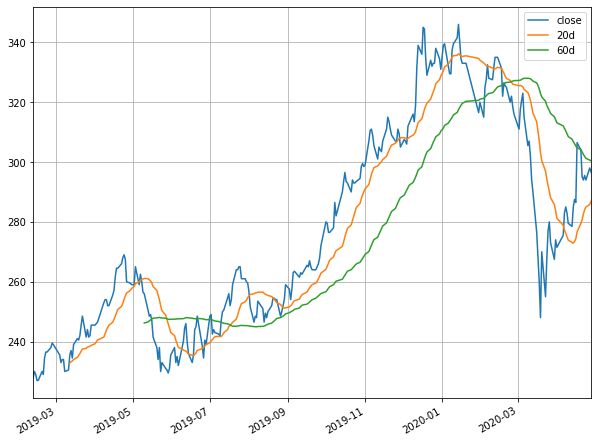

In [22]:
# 將收盤價、20日均線、60日均線，合併為一張圖表
df[['close','20d','60d']].plot(grid=True, figsize=(10,8))

In [23]:
# Donchian Channel (DC指標)
df['20d_high'] = pd.Series.rolling(df['close'], window=20).max()
df['10d_low'] = pd.Series.rolling(df['close'], window=10).min()

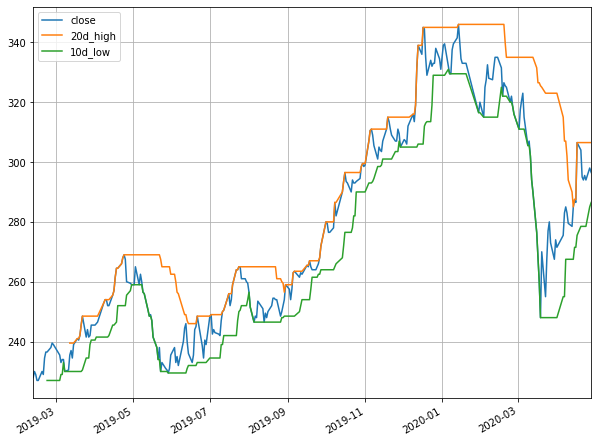

In [24]:
df[['close','20d_high','10d_low']].plot(grid=True, figsize=(10,8))

# 設計進出策略

In [25]:
#  突破策略
def breakout(df):
    # DC指標
    df['20d_high'] = pd.Series.rolling(df['close'], window=20).max()
    df['10d_low'] = pd.Series.rolling(df['close'], window=10).min()

    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

    # 在下面把 signals 跟 positions 畫出來做說明
    df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (10, 8))

In [26]:
def apply_strategy(strategy, df):
    return strategy(df)

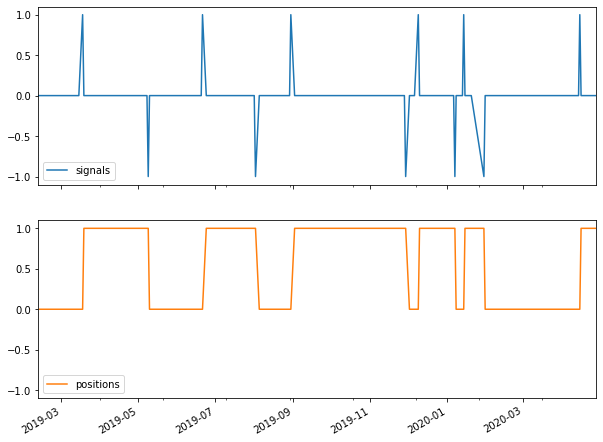

In [27]:
apply_strategy(breakout, df)

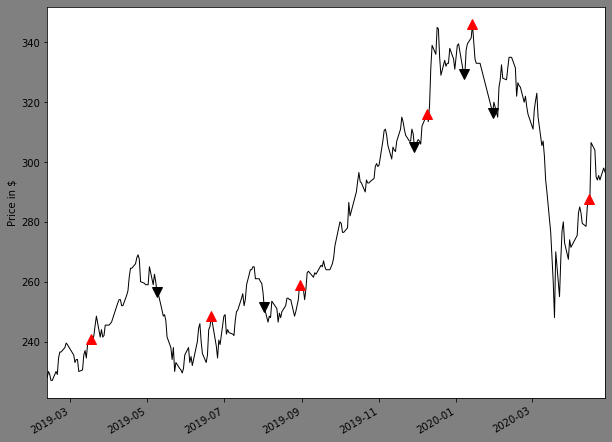

In [45]:
fig = plt.figure()
fig.patch.set_facecolor('gray')     #設計表框顏色
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
df['close'].plot(ax=ax1, color='black', lw=1., figsize=(10,8))

#繪製買進點
ax1.plot(df.loc[df.signals == 1].index,df['close'][df.signals == 1.0],'^', markersize=10, color='r') 

#繪製賣出點
ax1.plot(df.loc[df.signals == -1].index, df['close'][df.signals == -1.0], 'v', markersize=10, color='k')

In [29]:
dailyRet = df['close'].pct_change()

In [30]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = (dailyRet - 0.04/252)[df['positions']==1]

# 計算shaperatio
sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)

In [31]:
sharpeRatio

1.4320666641310382

# 計算MaxDD跟MaxDDD

In [32]:
cumRet = np.cumprod(1 + excessRet)

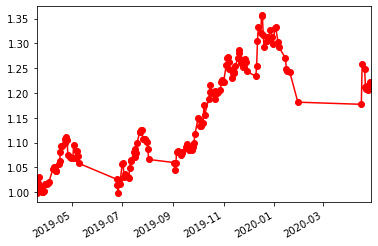

In [33]:
cumRet.plot(style='ro-')